In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import numpy as np
import matplotlib.pyplot as plt
from feature_manager import FeatureManager
from dnn_multi_class_classifier import MultiClassDNNClassifer
from sklearn.preprocessing import LabelEncoder
from random import randint
from keras import callbacks
from keras import losses
from visualizer import *
from keras.utils import np_utils

2023-01-16 00:35:37.642280: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-16 00:35:37.642404: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-16 00:35:37.642419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
data = pd.read_csv("../data/BTCUSDT-1h.csv", parse_dates=["Open Time"], index_col = "Open Time")
granular_data = pd.read_csv("../nocommit/BTCUSDT-1m.csv", parse_dates=["Open Time"], index_col = "Open Time")
fm: FeatureManager = FeatureManager()
fm.build_feature(data=data,lags=5)

tp = 0.03
sl = 0.015
md = 28
timeframe_in_ms = 60*60*1000

fm.prepare_trade_forward_data(
    data=fm.df,
    take_profit_rate=tp,
    stop_loss_rate=sl,
    max_duration=md,
    granular_data=granular_data,
    timeframe_in_ms=timeframe_in_ms
)

Processing 1/28
Processing 2/28
Processing 3/28
Processing 4/28
Processing 5/28
Processing 6/28
Processing 7/28
Processing 8/28
Processing 9/28
Processing 10/28
Processing 11/28
Processing 12/28
Processing 13/28
Processing 14/28
Processing 15/28
Processing 16/28
Processing 17/28
Processing 18/28
Processing 19/28
Processing 20/28
Processing 21/28
Processing 22/28
Processing 23/28
Processing 24/28
Processing 25/28
Processing 26/28
Processing 27/28
Processing 28/28


In [13]:
300 * 28

8400

In [17]:
fm.df["trade_signal"].value_counts()

0    23065
1    11918
2    11845
Name: trade_signal, dtype: int64

In [18]:
classifier = MultiClassDNNClassifer()
classifier.prepare_data(data = fm.df,cols = fm.cols,random_state=randint(0,100),target_col="trade_signal")


Train = 32779, Val = 7024, Test = 7025, All = 46828


In [15]:
classifier.configure(hu = 100, dropout=True, class_num = 3, input_dim=len(fm.cols))
classifier.run(gpu = True,epochs = 200, patience = 5)
classifier.model.evaluate(classifier.x_test,classifier.y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               11100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                                 
Total params: 13,703
Trainable params: 13,703
Non-trainable params: 0
_________________________________________________________________


2023-01-16 00:44:08.478985: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-01-16 00:44:08.479074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: andy-GA-970A-D3
2023-01-16 00:44:08.479101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: andy-GA-970A-D3
2023-01-16 00:44:08.479372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.61.5
2023-01-16 00:44:08.479447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.61.5
2023-01-16 00:44:08.479472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 520.61.5


Epoch 1/200

Epoch 1: val_loss improved from inf to 1.13509, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 5s - loss: 1.7367 - accuracy: 0.3745 - val_loss: 1.1351 - val_accuracy: 0.3064 - 5s/epoch - 5ms/step
Epoch 2/200

Epoch 2: val_loss improved from 1.13509 to 1.12317, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 4s - loss: 1.6400 - accuracy: 0.4196 - val_loss: 1.1232 - val_accuracy: 0.2995 - 4s/epoch - 4ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.12317 to 1.12135, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 4s - loss: 1.6249 - accuracy: 0.4306 - val_loss: 1.1213 - val_accuracy: 0.2936 - 4s/epoch - 4ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.12135 to 1.11870, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 3s - loss: 1.6188 - accuracy: 0.4306 - val_loss: 1.1187 - val_accuracy: 0.2931 - 3s/epoch - 3ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 1.11870
1025/1025 - 4s - loss: 1.6098 - accuracy

[1.02686607837677, 0.443131685256958]

In [ ]:
pd.DataFrame(classifier.y_test).value_counts()

In [ ]:
pd.DataFrame(classifier.pred_class).value_counts()


======= Lap 1 =======
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               11100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                                 
Total params: 13,703
Trainable params: 13,703
Non-trainable params: 0
_________________________________________________________________
Train = 32779, Val = 7024, Te

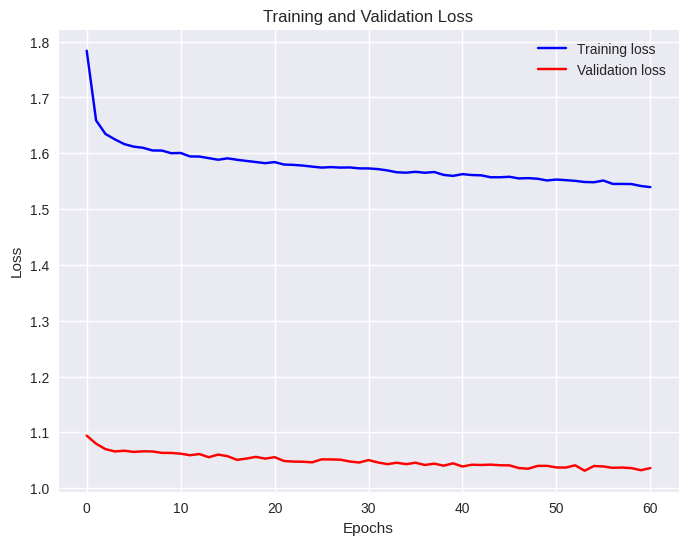

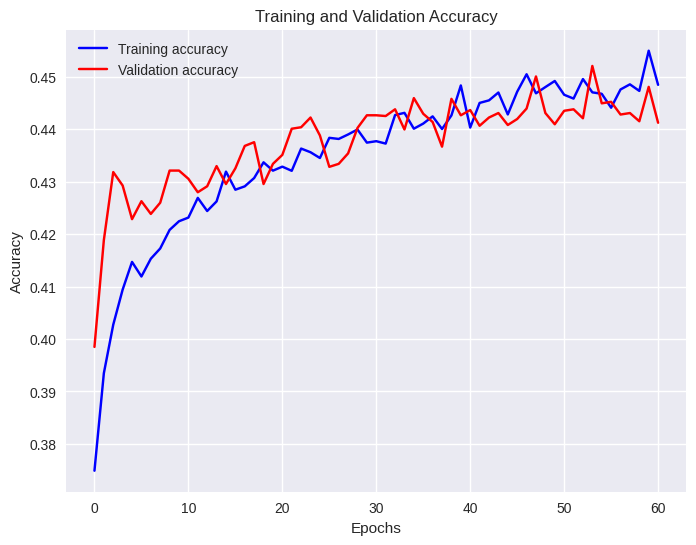

220/220 [==============================] - 0s 2ms/step - loss: 1.0345 - accuracy: 0.4386

======= Lap 2 =======
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               11100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                                 
Total params: 13,703
Trainable params: 13,703
Non-trainable params: 0
______

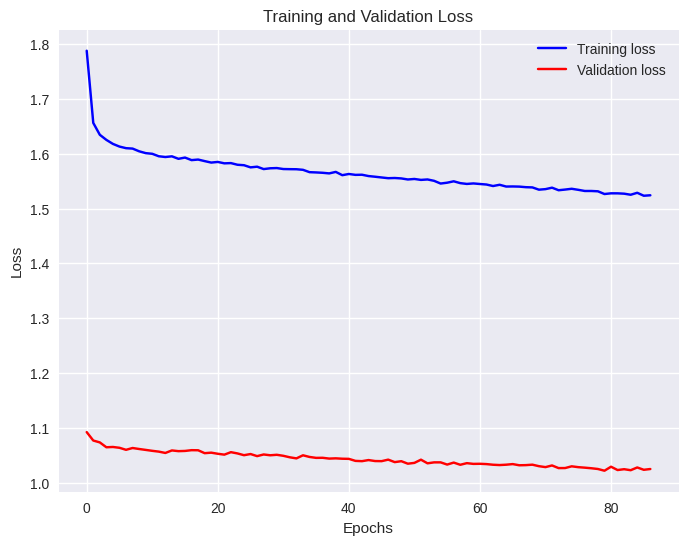

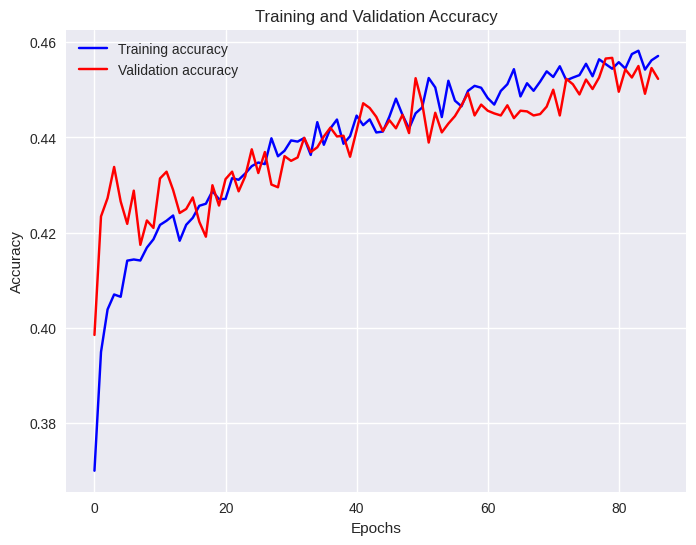

220/220 [==============================] - 1s 2ms/step - loss: 1.0226 - accuracy: 0.4483

======= Lap 3 =======
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               11100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                                 
Total params: 13,703
Trainable params: 13,703
Non-trainable params: 0
______

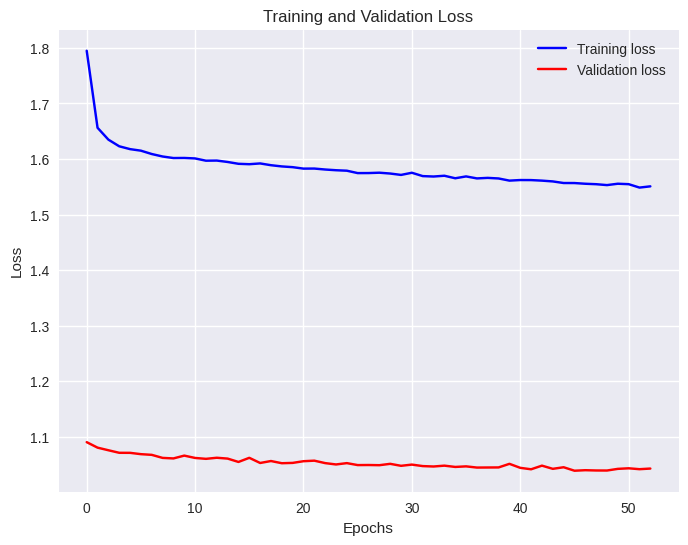

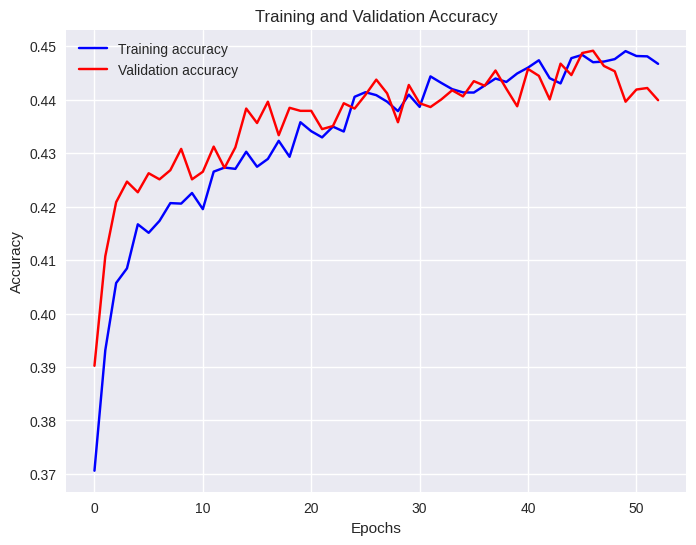

220/220 [==============================] - 0s 2ms/step - loss: 1.0362 - accuracy: 0.4444

======= Lap 4 =======
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               11100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                                 
Total params: 13,703
Trainable params: 13,703
Non-trainable params: 0
______

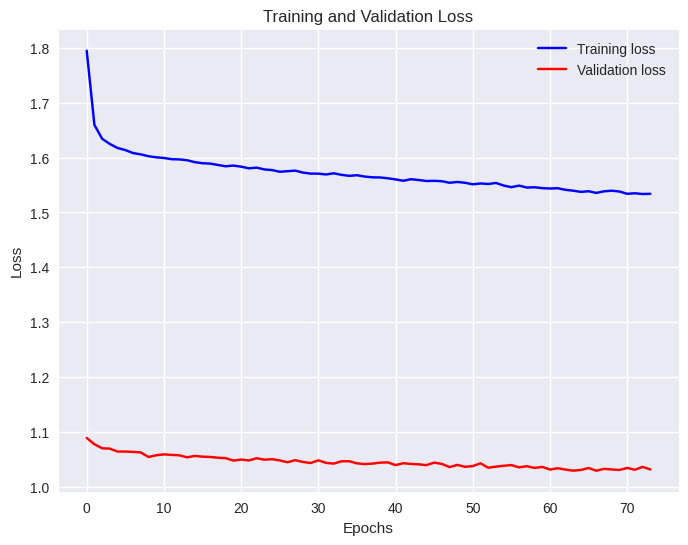

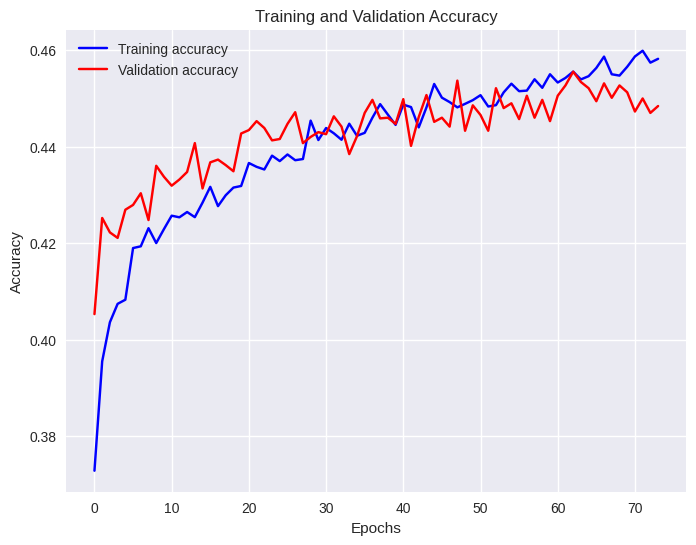

220/220 [==============================] - 1s 2ms/step - loss: 1.0292 - accuracy: 0.4500

======= Lap 5 =======
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               11100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                                 
Total params: 13,703
Trainable params: 13,703
Non-trainable params: 0
______

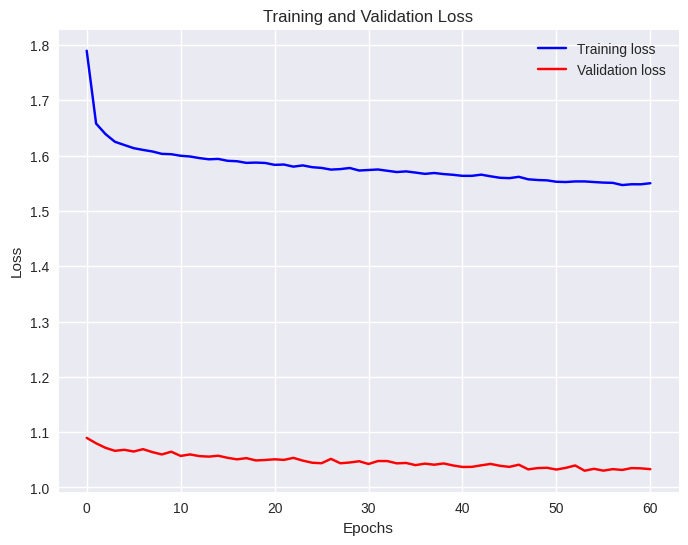

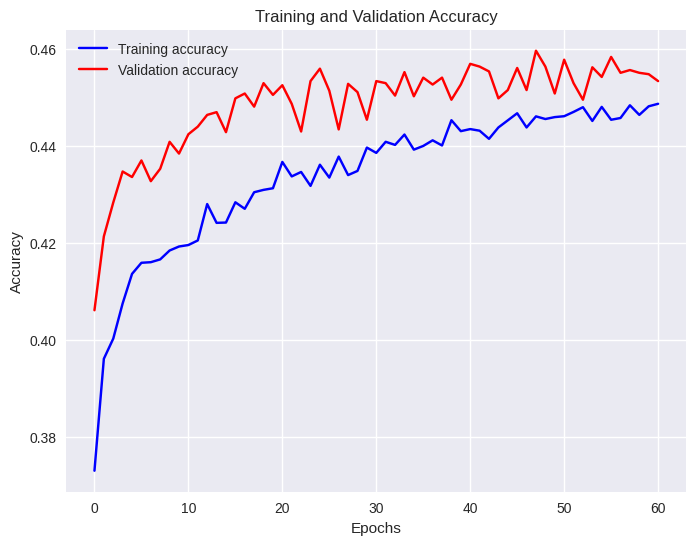

220/220 [==============================] - 0s 2ms/step - loss: 1.0368 - accuracy: 0.4360

Accuracy mean: 0.44344483613967894, std: 0.005394543780087153
Loss mean: 1.0318699598312377, std: 0.005339202725327891


In [19]:
acc_list = []
loss_list = []
laps = 5

for i in range (0,laps):
    print("\n======= Lap {} =======".format(i+1))
    callbacks.backend.clear_session()
    
    classifier = MultiClassDNNClassifer()
    
    classifier.configure(
        hu = 100, 
        dropout=True, 
        input_dim=len(fm.cols),
        class_num=3
    )
    
    classifier.prepare_data(
        data = fm.df,
        cols = fm.cols,
        shuffle = True, 
        random_state=i+1,
        target_col="trade_signal"
    )
    
    classifier.run(gpu = True,epochs=100, patience=7)
    classifier.visualize_loss()
    classifier.visualize_accuracy()
    
    test_results = classifier.model.evaluate(
        classifier.x_test,
        classifier.y_test
    )

    acc_list.append(test_results[1])
    loss_list.append(test_results[0])

acc_arr = np.array(acc_list)
loss_arr = np.array(loss_list)

print("\n======")
print("Accuracy mean: {}, std: {}".format(acc_arr.mean(),acc_arr.std()))
print("Loss mean: {}, std: {}".format(loss_arr.mean(),loss_arr.std()))
print("======")